In [28]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

from sklearn import linear_model
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

In [2]:
# Helper functions
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [3]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = len(files)
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

Loading 100 images
satImage_078.png
Loading 100 images
satImage_078.png


Image size = 400,400


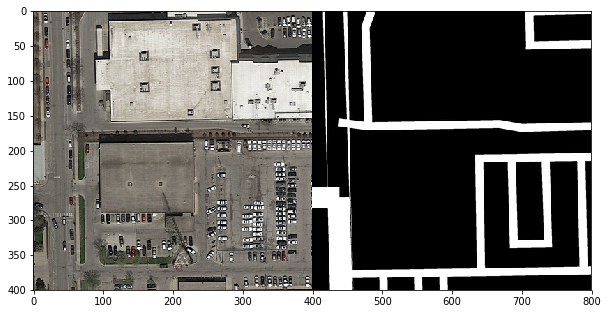

In [4]:
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

# Show first image and its groundtruth image
cimg = concatenate_images(imgs[0], gt_imgs[0])
fig1 = plt.figure(figsize=(10, 10))
_ = plt.imshow(cimg, cmap='Greys_r')

In [5]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print(img_patches.shape)
print(gt_patches.shape)

(62500, 16, 16, 3)
(62500, 16, 16)


In [6]:
# Extract 6-dimensional features consisting of average RGB color as well as variance
def extract_features(img):
    feat_m = np.mean(img, axis=(0,1))
    feat_v = np.var(img, axis=(0,1))
    feat = np.append(feat_m, feat_v)
    return feat

# Extract 2-dimensional features consisting of average gray color as well as variance
def extract_features_2d(img):
    feat_m = np.mean(img)
    feat_v = np.var(img)
    feat = np.append(feat_m, feat_v)
    return feat

# Extract features for a given image
def extract_img_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
    return X

def extract_img_features_6d(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
    return X

In [7]:
# Compute features for each image patch
foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

def value_to_class(v):
    df = np.sum(v)
    if df > foreground_threshold:
        return 1
    else:
        return 0

X = np.asarray([ extract_features_2d(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

In [8]:
# Print feature statistics
print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(len(np.unique(Y))))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 62500 features
Feature dimension = 2
Number of classes = 2
Class 0: 46309 samples
Class 1: 16191 samples


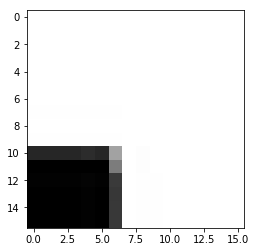

In [9]:
# Display a patch that belongs to the foreground class
_ = plt.imshow(gt_patches[Y1[3]], cmap='Greys_r')

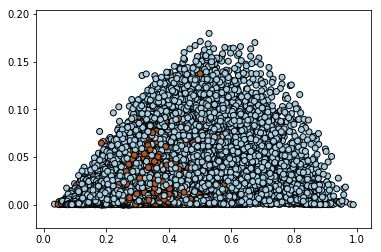

In [10]:
# Plot 2d features using groundtruth to color the datapoints
_ = plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

In [11]:
# Train a logistic regression classifier
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [12]:
# Predict on the training set
Z = logreg.predict(X)

# Compute the F1-score
F1 = f1_score(Y, Z)
print(f'F1-score is {F1}')

F1-score is 0.44221065596567205


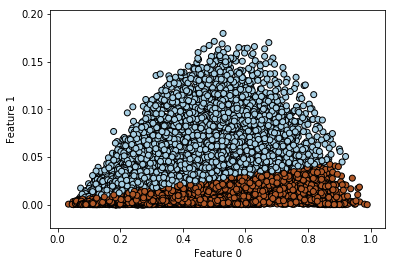

In [13]:
# Plot features using predictions to color datapoints
plt.scatter(X[:, 0], X[:, 1], c=Z, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 0')
_ = plt.ylabel('Feature 1')

In [14]:
# Convert array of labels to an image
def label_to_img(imgwidth, imgheight, w, h, labels):
    im = np.zeros([imgwidth, imgheight])
    idx = 0
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            im[j:j+w, i:i+h] = labels[idx]
            idx = idx + 1
    return im

def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

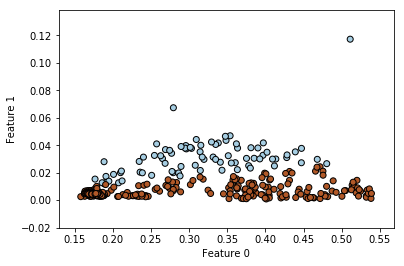

In [15]:
# Run prediction on the img_idx-th image
img_idx = 12

Xi = extract_img_features(image_dir + files[img_idx])
Zi = logreg.predict(Xi)
plt.scatter(Xi[:, 0], Xi[:, 1], c=Zi, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Feature 0')
_ = plt.ylabel('Feature 1')

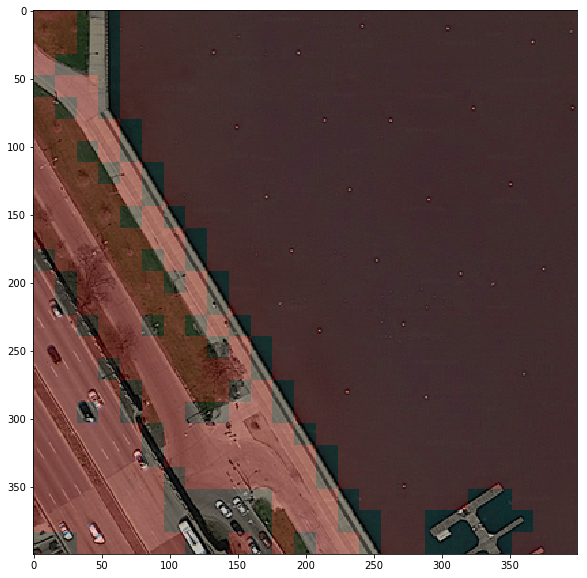

In [16]:
# Display prediction as an image
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

_ = plt.imshow(new_img)

Clearly, the two dimensions are not linearly separable, so let's try to use the 6 dimensions (mean & variance for each color channel)

In [17]:
X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(gt_patches[i]) for i in range(len(gt_patches))])

In [18]:
print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
print('Number of classes = ' + str(len(np.unique(Y))))

Y0 = [i for i, j in enumerate(Y) if j == 0]
Y1 = [i for i, j in enumerate(Y) if j == 1]
print('Class 0: ' + str(len(Y0)) + ' samples')
print('Class 1: ' + str(len(Y1)) + ' samples')

Computed 62500 features
Feature dimension = 6
Number of classes = 2
Class 0: 42026 samples
Class 1: 20474 samples


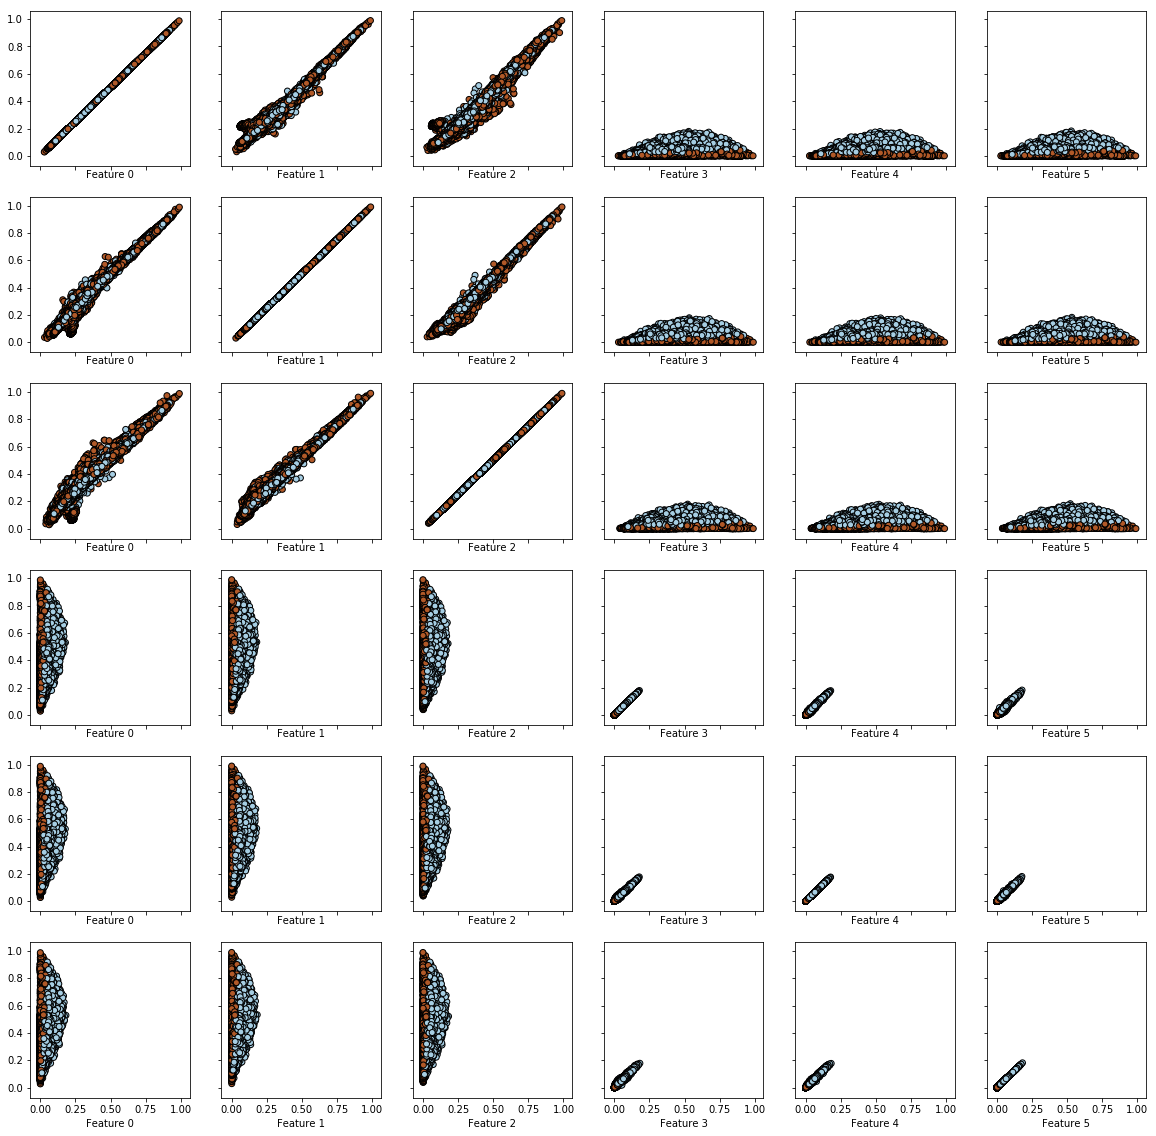

In [19]:
fig, ax = plt.subplots(6, 6, sharex='col', sharey='row', figsize=(20, 20))
for i in range(6):
    for j in range(6):
        ax[i, j].scatter(X[:, i], X[:, j], c=Z, edgecolors='k', cmap=plt.cm.Paired)
        ax[i, j].set_xlabel(f'Feature {i}')
        ax[i, j].set_ylabel(f'Feature {j}')

In [20]:
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [21]:
# Predict on the training set
Z = logreg.predict(X)

# Compute the F1-score
F1 = f1_score(Y, Z)
print(f'F1-score is {F1}')

F1-score is 0.5255361942893664


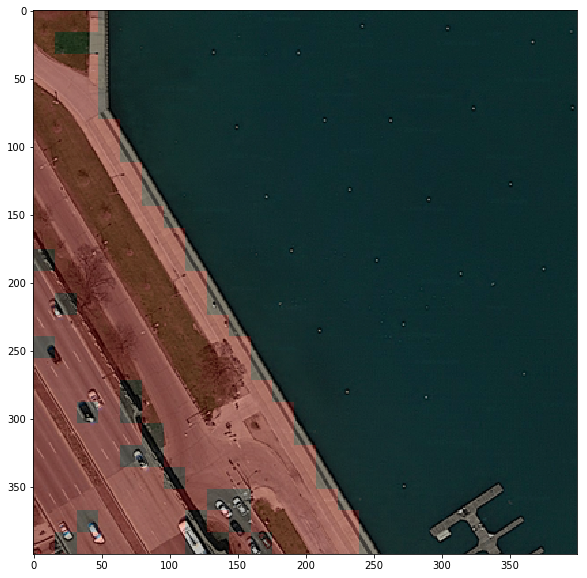

In [22]:
# Display prediction as an image
img_idx = 12

Xi = extract_img_features_6d(image_dir + files[img_idx])
Zi = logreg.predict(Xi)

w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

_ = plt.imshow(new_img)

Although the true positive rate increased, we can see that the model does not do a very good job on predicting anything useful. Let's add some more polynomial features.

In [23]:
def build_poly(X, degree):
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(X)

Degree 2
(62500, 28)
(62500, 28)
F1-score is 0.5788485607008761
Degree 3


KeyboardInterrupt: 

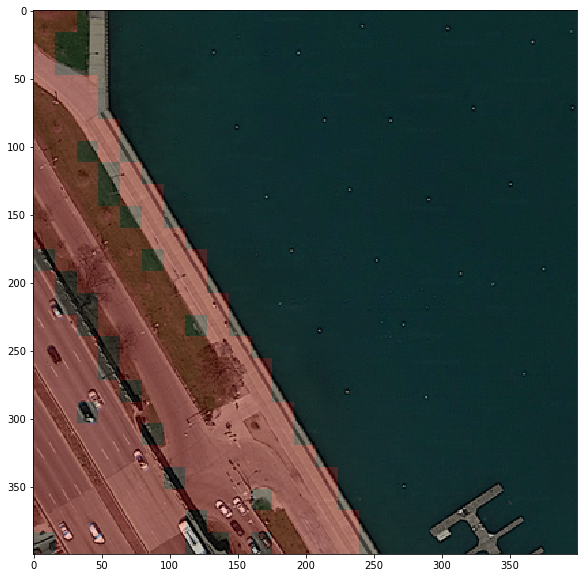

In [99]:
def train(X, Y):
    logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
    logreg.fit(X, Y)
    # Predict on the training set
    Z = logreg.predict(X)

    # Compute the F1-score
    F1 = f1_score(Y, Z)
    print(f'F1-score is {F1}')
    return logreg

def show(logreg, img_idx, degree):
    Xi = build_poly(extract_img_features_6d(image_dir + files[img_idx]), degree)
    Zi = logreg.predict(Xi)

    w = gt_imgs[img_idx].shape[0]
    h = gt_imgs[img_idx].shape[1]
    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
    cimg = concatenate_images(imgs[img_idx], predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

    new_img = make_img_overlay(imgs[img_idx], predicted_im)

    plt.imshow(new_img)
    
for DEGREE in range(2, 10):
    print(f'Degree {DEGREE}')
    X = build_poly(np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))]), DEGREE)
    Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
    print(X.shape)

    logreg = train(X, Y)
    show(logreg, 12, DEGREE)

Seeing that the up to the $4th$ and $7th$ degree polynomial did not add anothing useful, we will drop this idea and instead use as features all the pixel's values. I.e. the dimension of the features will be $16 * 16 * 3$.

In [25]:
def extract_pixel_features(img):
    return img.reshape(-1)

def extract_img_pixel_features(filename):
    img = load_image(filename)
    img_patches = img_crop(img, patch_size, patch_size)
    X = np.asarray([ extract_pixel_features(img_patches[i]) for i in range(len(img_patches))])
    return X

In [26]:
X = np.asarray([extract_pixel_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

print('Feature dimension = ' + str(X.shape[1]))

def train(X, Y):
    logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
    logreg.fit(X, Y)
    # Predict on the training set
    Z = logreg.predict(X)

    # Compute the F1-score
    F1 = f1_score(Y, Z)
    print(f'F1-score is {F1}')
    return logreg

def show(logreg, img_idx):
    Xi = build_poly(extract_img_pixel_features(image_dir + files[img_idx]), DEGREE)
    Zi = logreg.predict(Xi)

    w = gt_imgs[img_idx].shape[0]
    h = gt_imgs[img_idx].shape[1]
    predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
    cimg = concatenate_images(imgs[img_idx], predicted_im)
    fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
    plt.imshow(cimg, cmap='Greys_r')

    new_img = make_img_overlay(imgs[img_idx], predicted_im)

    plt.imshow(new_img)
    
logreg = train(X, Y)

Feature dimension = 768
F1-score is 0.4361799416452554


This model again, does not perform better than the other ones. Clearly, we must change our focut to a more suitable model for images, such as the Convolutional Neural Network model.

But, before going on to test CNNs, seeing that the polynomial features gave the best results for the logistic regression segmentation, we will further analyze this kind of setting. We will make use of cross-validation and bias-variance decomposition, to detect when the model starts overfitting.
Afterwards, we will make predictions using the best polynomial features model on the test set and submit them for evaluation on the CrowdAI platform.

In [102]:
def build_k_indices(n, k_fold, seed):
    # Do the k-fold used in cross-validation
    interval = int(n / k_fold)
    inds = np.random.permutation(n)
    np.random.seed(seed)
    k_indices = [inds[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)


def cross_validation(y, x, k_indices, k, degree):
    # Split data in train and test
    te_ind = k_indices[k]
    tr_ind = k_indices[~(np.arange(k_indices.shape[0]) == k)].reshape(-1)
    y_te, y_tr = y[te_ind], y[tr_ind]
    x_te, x_tr = x[te_ind], x[tr_ind]
    # Build polynomial features
    tx_te, tx_tr = build_poly(x_te, degree), build_poly(x_tr, degree)
    # Train logistic regression model
    model = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
    model.fit(tx_tr, y_tr)
    # Compute the loss on the train and test data
    pred_tr = model.predict(tx_tr)
    loss_tr = np.sqrt(2 * mean_squared_error(y_tr, pred_tr))
    pred_te = model.predict(tx_te)
    loss_te = np.sqrt(2 * mean_squared_error(y_te, pred_te))
    # Compute F1-score on the train and test data
    f1_tr = f1_score(pred_tr, y_tr)
    f1_te = f1_score(pred_te, y_te)
    return loss_tr, loss_te, f1_tr, f1_te


def bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te):
    """visualize the bias variance decomposition."""
    rmse_tr_mean = np.expand_dims(np.mean(rmse_tr, axis=0), axis=0)
    rmse_te_mean = np.expand_dims(np.mean(rmse_te, axis=0), axis=0)
    plt.plot(degrees, rmse_tr.T, 'b', linestyle="-", color=([0.7, 0.7, 1]), label='train', linewidth=0.3)
    plt.plot(degrees, rmse_te.T, 'r', linestyle="-", color=[1, 0.7, 0.7], label='test', linewidth=0.3)
    plt.plot(degrees, rmse_tr_mean.T, 'b', linestyle="-", label='train', linewidth=3)
    plt.plot(degrees, rmse_te_mean.T, 'r', linestyle="-", label='test', linewidth=3)
    plt.ylim(0.907327, 0.90736)
    plt.xlabel("degree")
    plt.ylabel("error")
    plt.title("Bias-Variance Decomposition")
    plt.savefig("bias_variance")

In [ ]:
# Do cross-validation over multiple seeds and degrees
seeds = range(1, 11)
degrees = range(1, 11)
k_fold = 4

# Construct basic data
X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])

# Prepare matrices to store losses and F1-scores
rmse_tr = np.empty((len(seeds), len(degrees)))
rmse_te = np.empty((len(seeds), len(degrees)))
f1_tr = np.empty((len(seeds), len(degrees)))
f1_te = np.empty((len(seeds), len(degrees)))

for ind_seed, seed in enumerate(seeds):
    np.random.seed(seed)
    for ind_degree, degree in enumerate(degrees):
        print(f'Processing seed {seed} and degree {degree}')
        # Split data in folds
        k_indices = build_k_indices(X.shape[0], k_fold, seed)
        # Perform cross validation
        rmse_tr_tmp, rmse_te_tmp = [], []
        f1_tr_tmp, f1_te_tmp = [], []
        for k in range(k_fold):
            loss_tr, loss_te, f_tr, f_te = cross_validation(Y, X, k_indices, k, degree)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
            f1_tr_tmp.append(f_tr)
            f1_te_tmp.append(f_te)
        rmse_tr[ind_seed, ind_degree] = np.mean(rmse_tr_tmp)
        rmse_te[ind_seed, ind_degree] = np.mean(rmse_te_tmp)
        f1_tr[ind_seed, ind_degree] = np.mean(f1_tr_tmp)
        f1_te[ind_seed, ind_degree] = np.mean(f1_te_tmp)

Processing seed 1 and degree 1
Processing seed 1 and degree 2
Processing seed 1 and degree 3
Processing seed 1 and degree 4
Processing seed 1 and degree 5
Processing seed 1 and degree 6
Processing seed 1 and degree 7
Processing seed 1 and degree 8
Processing seed 1 and degree 9
Processing seed 1 and degree 10


In [55]:
np.min(rmse_tr)

0.9073533863991436

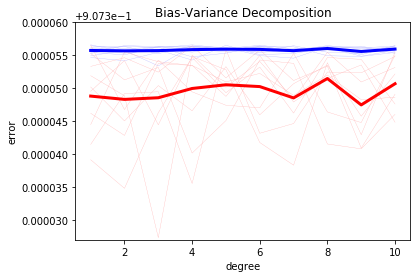

In [57]:
bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te)